Mounted at /content/drive
Working directory: /content/drive/MyDrive/ML Projects/SPD
Loaded dataset with shape: (6607, 20)
   Hours_Studied  Attendance Parental_Involvement Access_to_Resources  \
0             23          84                  Low                High   
1             19          64                  Low              Medium   
2             24          98               Medium              Medium   
3             29          89                  Low              Medium   
4             19          92               Medium              Medium   

  Extracurricular_Activities  Sleep_Hours  Previous_Scores Motivation_Level  \
0                         No            7               73              Low   
1                         No            8               59              Low   
2                        Yes            7               91           Medium   
3                        Yes            8               98           Medium   
4                        Yes            6   

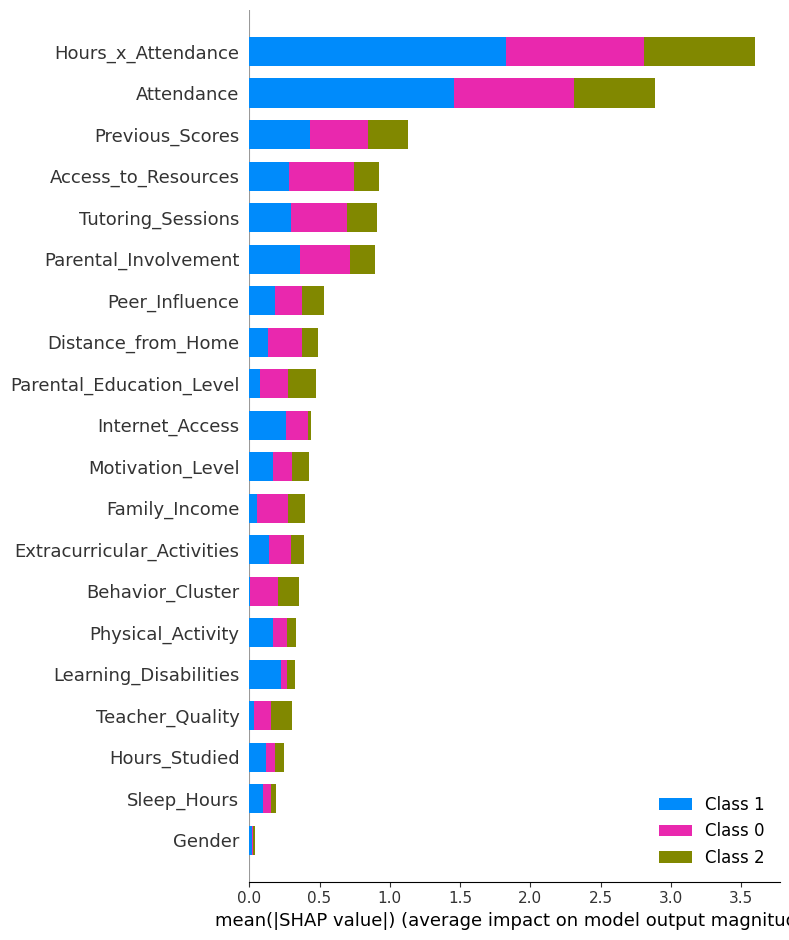

Model saved to spd_xgb_model.pkl


In [ ]:

# ──────────────────────────────────────────────────────────────────────────────
# Step 01: (Re)Mount Google Drive
# ──────────────────────────────────────────────────────────────────────────────
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ──────────────────────────────────────────────────────────────────────────────
# Step 02: Set Working Directory
# ──────────────────────────────────────────────────────────────────────────────
import os
data_dir = '/content/drive/MyDrive/ML Projects/SPD'
os.makedirs(data_dir, exist_ok=True)
os.chdir(data_dir)
print(f"Working directory: {os.getcwd()}")

# ──────────────────────────────────────────────────────────────────────────────
# Step 03: Install & Import Libraries
# ──────────────────────────────────────────────────────────────────────────────
#!pip install xgboost shap --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

import shap
import joblib

# ──────────────────────────────────────────────────────────────────────────────
# Step 04: Load Dataset
# ──────────────────────────────────────────────────────────────────────────────
file_name = 'StudentPerformanceFactors.csv'
df = pd.read_csv(file_name)
print(f"Loaded dataset with shape: {df.shape}")

# ──────────────────────────────────────────────────────────────────────────────
# Step 05: Initial Exploration
# ──────────────────────────────────────────────────────────────────────────────
print(df.head(), '\n')
print(df.info(), '\n')
print(df.describe().T, '\n')

# ──────────────────────────────────────────────────────────────────────────────
# Step 06: Create Categorical Target from Exam_Score
# ──────────────────────────────────────────────────────────────────────────────
bins   = [0, 60, 70, np.inf]
labels = ['Low', 'Medium', 'High']
df['Exam_Category'] = pd.cut(df['Exam_Score'], bins=bins, labels=labels)
print(df['Exam_Category'].value_counts(), '\n')

# ──────────────────────────────────────────────────────────────────────────────
# Step 07: Handle Missing Values
# ──────────────────────────────────────────────────────────────────────────────
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.drop('Exam_Category').tolist()

df[num_cols] = SimpleImputer(strategy='median').fit_transform(df[num_cols])
df[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(df[cat_cols])

# ──────────────────────────────────────────────────────────────────────────────
# Step 08: Encode Categorical Variables
# ──────────────────────────────────────────────────────────────────────────────
le = LabelEncoder()
for col in cat_cols + ['Exam_Category']:
    df[col] = le.fit_transform(df[col].astype(str))

# ──────────────────────────────────────────────────────────────────────────────
# Step 09: Feature Engineering
# ──────────────────────────────────────────────────────────────────────────────
df['Hours_x_Attendance'] = df['Hours_Studied'] * df['Attendance']
# (add any additional engineered features here)

# ──────────────────────────────────────────────────────────────────────────────
# Step 10: Clustering Behavioral Profiles
# ──────────────────────────────────────────────────────────────────────────────
behav_feats = ['Hours_Studied', 'Attendance', 'Motivation_Level', 'Sleep_Hours']
df['Behavior_Cluster'] = KMeans(n_clusters=4, random_state=42).fit_predict(df[behav_feats])
print("Cluster distribution:\n", df['Behavior_Cluster'].value_counts(), '\n')

# ──────────────────────────────────────────────────────────────────────────────
# Step 11: Prepare Data for Modeling
# ──────────────────────────────────────────────────────────────────────────────
target    = 'Exam_Category'
drop_cols = ['Exam_Score']
features  = [c for c in df.columns if c not in drop_cols + [target]]

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_feats_to_scale = [c for c in num_cols if c in features]
scaler = StandardScaler()
X_train[numeric_feats_to_scale] = scaler.fit_transform(X_train[numeric_feats_to_scale])
X_test[numeric_feats_to_scale]  = scaler.transform(X_test[numeric_feats_to_scale])

# ──────────────────────────────────────────────────────────────────────────────
# Step 12: Model Training & Hyperparameter Tuning
# ──────────────────────────────────────────────────────────────────────────────
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
param_grid = {
    'n_estimators':   [100, 200],
    'max_depth':      [3, 5],
    'learning_rate':  [0.01, 0.1]
}

cv   = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(xgb, param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_, '\n')
model = grid.best_estimator_

# ──────────────────────────────────────────────────────────────────────────────
# Step 13: Evaluation on Test Set
# ──────────────────────────────────────────────────────────────────────────────
y_pred = model.predict(X_test)
print("Test Accuracy: ", accuracy_score(y_test, y_pred))
print("Test Macro F1:  ", f1_score(y_test, y_pred, average='macro'))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred), '\n')

# ──────────────────────────────────────────────────────────────────────────────
# Step 14: Interpretability with SHAP (Fixed)
# ──────────────────────────────────────────────────────────────────────────────
explainer   = shap.TreeExplainer(model)
shap_vals   = explainer.shap_values(X_test)

# Summary bar plot
shap.summary_plot(shap_vals, X_test, plot_type="bar", show=False)
plt.tight_layout(); plt.savefig('shap_summary_bar.png'); plt.show()
# ──────────────────────────────────────────────────────────────────────────────
# Step 15: Save Final Model
# ──────────────────────────────────────────────────────────────────────────────
joblib.dump(model, 'spd_xgb_model.pkl')
print("Model saved to spd_xgb_model.pkl")

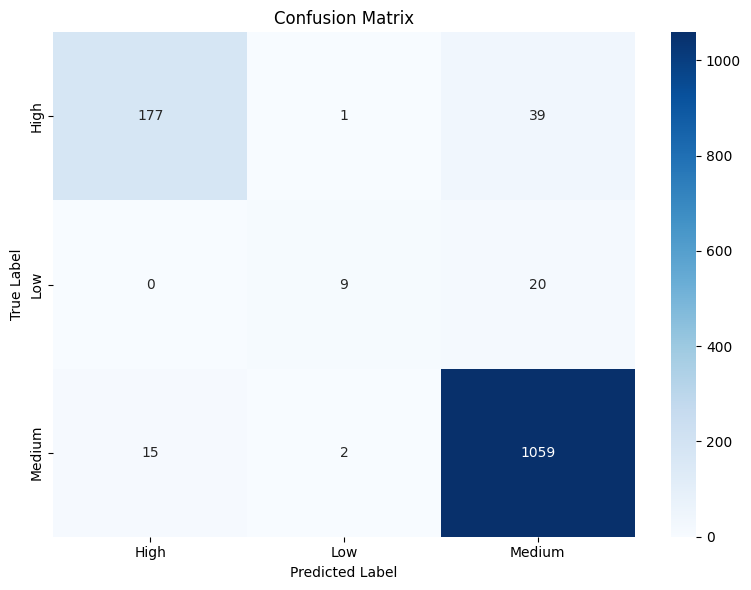

In [9]:
# prompt: visualize confusion matrix

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

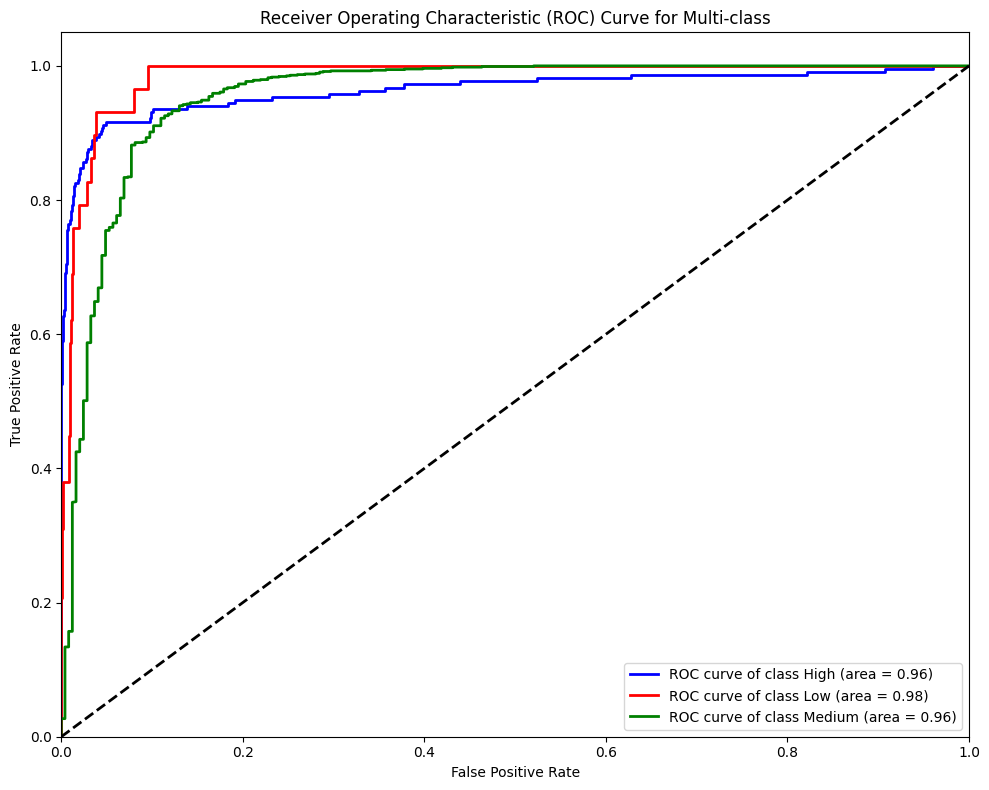

In [10]:
# prompt: visualize roc curve

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
# ──────────────────────────────────────────────────────────────────────────────
# Step 16: Visualize ROC Curve
# ──────────────────────────────────────────────────────────────────────────────
# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]
# Get predicted probabilities for each class
y_prob = model.predict_proba(X_test)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves
plt.figure(figsize=(10, 8))
lw = 2
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(le.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()

Exam Category

In [11]:
# Instead of just typing 'Exam_Category', access it from the DataFrame:
# To see the value counts of the 'Exam_Category' column
print(df['Exam_Category'].value_counts())

# To see the first few entries of the 'Exam_Category' column
# print(df['Exam_Category'].head())

Exam_Category
2    5379
0    1083
1     145
Name: count, dtype: int64


df.describe().T

In [12]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Hours_Studied,6607.0,19.975329,5.990594,1.0,16.0,20.0,24.0,44.0
Attendance,6607.0,79.977448,11.547475,60.0,70.0,80.0,90.0,100.0
Parental_Involvement,6607.0,1.220070,0.865634,0.0,0.0,2.0,2.0,2.0
Access_to_Resources,6607.0,1.203421,0.871783,0.0,0.0,2.0,2.0,2.0
Extracurricular_Activities,6607.0,0.596035,0.490728,0.0,0.0,1.0,1.0,1.0
Sleep_Hours,6607.0,7.029060,1.468120,4.0,6.0,7.0,8.0,10.0
Previous_Scores,6607.0,75.070531,14.399784,50.0,63.0,75.0,88.0,100.0
Motivation_Level,6607.0,1.307553,0.782515,0.0,1.0,2.0,2.0,2.0
Internet_Access,6607.0,0.924474,0.264258,0.0,1.0,1.0,1.0,1.0
Tutoring_Sessions,6607.0,1.493719,1.230570,0.0,1.0,1.0,2.0,8.0


In [13]:
# prompt: macro F1-score

print("Test Macro F1:  ", f1_score(y_test, y_pred, average='macro'))

Test Macro F1:   0.7566367118472342
